In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets import CIFAR10, CIFAR100, MNIST, FashionMNIST
import torchvision.transforms as transforms
import task_complexity
import matplotlib.pyplot as plt

In [2]:
class Repeat(object):
    def __init__(self, repeats):
        self.repeats = repeats
    
    def __call__(self, tensor):
        return torch.stack((tensor,)*self.repeats, dim = 1)
    
    def __repr__(self):
        return self.__class__.__name__ + '(repeats = {})'.format(self.repeats)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(32),
    Repeat(3),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

target_transform_cifar10 = transforms.Compose([
    lambda x: torch.tensor(x),
    lambda x: F.one_hot(x, num_classes = 10)
    ])
target_transform_cifar100 = transforms.Compose([
    lambda x: torch.tensor(x),
    lambda x: F.one_hot(x, num_classes = 100)
    ])

batch_size = 128

trainset_cifar10 = CIFAR10(root = '~/datasets/CIFAR10', train = True, transform = transform, target_transform = target_transform_cifar10, download = True)
trainloader_cifar10 = torch.utils.data.DataLoader(trainset_cifar10, batch_size = batch_size, shuffle = True, num_workers = 2)

trainset_cifar100 = CIFAR100(root = '~/datasets/CIFAR100', train = True, transform = transform, target_transform = target_transform_cifar100, download = True)
trainloader_cifar100 = torch.utils.data.DataLoader(trainset_cifar100, batch_size = batch_size, shuffle = True, num_workers = 2)

trainset_mnist = MNIST(root = '~/datasets', train = True, transform = mnist_transform, target_transform = target_transform_cifar10, download = True)
trainloader_mnist = torch.utils.data.DataLoader(trainset_mnist, batch_size = batch_size, shuffle = True, num_workers = 2)

trainset_fashionmnist = FashionMNIST(root = '~/datasets', train = True, transform = mnist_transform, target_transform = target_transform_cifar10, download = True)
trainloader_fashionmnist = torch.utils.data.DataLoader(trainset_fashionmnist, batch_size = batch_size, shuffle = True, num_workers = 2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class Net_CIFAR10(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim = 0)
        return x
    
class Net_CIFAR100(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 1024)
        self.fc2 = nn.Linear(1024, 100)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim = 0)
        return x

In [5]:
criterion = nn.CrossEntropyLoss(reduction = "none")

In [6]:
cifar10_scores = []
cifar100_scores = []
mnist_scores = []
fashionmnist_scores = []
for i in range(10):
    print("--------------------------------------------------------")
    print(f"ITERATION {i}")
    print("--------------------------------------------------------")
    complexity_score_cifar10 = task_complexity.compute_complexity(Net_CIFAR10, 10, trainloader_cifar10, criterion, n_bins = 100)
    cifar10_scores.append(complexity_score_cifar10)
    print(f"CIFAR10 Complexity Score: {complexity_score_cifar10}")

    complexity_score_cifar100 = task_complexity.compute_complexity(Net_CIFAR100, 10, trainloader_cifar100, criterion, n_bins = 100)
    cifar100_scores.append(complexity_score_cifar100)
    print(f"CIFAR100 Complexity Score: {complexity_score_cifar100}")
    
    complexity_score_mnist = task_complexity.compute_complexity(Net_CIFAR10, 10, trainloader_mnist, criterion, n_bins = 100)
    mnist_scores.append(complexity_score_mnist)
    print(f"MNIST Complexity Score: {complexity_score_mnist}")

    complexity_score_fashionmnist = task_complexity.compute_complexity(Net_CIFAR10, 10, trainloader_fashionmnist, criterion, n_bins = 100)
    fashionmnist_scores.append(complexity_score_fashionmnist)
    print(f"Fashion MNIST Complexity Score: {complexity_score_fashionmnist}")

--------------------------------------------------------
ITERATION 0
--------------------------------------------------------
CIFAR10 Complexity Score: 0.006754767488872382
CIFAR100 Complexity Score: 0.003037198847117839
MNIST Complexity Score: 0.02239525037293788
Fashion MNIST Complexity Score: 0.04369616636944196
--------------------------------------------------------
ITERATION 1
--------------------------------------------------------
CIFAR10 Complexity Score: 0.006435083356036042
CIFAR100 Complexity Score: 0.0024315787888840035
MNIST Complexity Score: 0.014892118644657781
Fashion MNIST Complexity Score: 0.032876883737460005
--------------------------------------------------------
ITERATION 2
--------------------------------------------------------
CIFAR10 Complexity Score: 0.0057116949771254255
CIFAR100 Complexity Score: 0.001774621576133395
MNIST Complexity Score: 0.02118493234497043
Fashion MNIST Complexity Score: 0.029743427310457538
--------------------------------------------

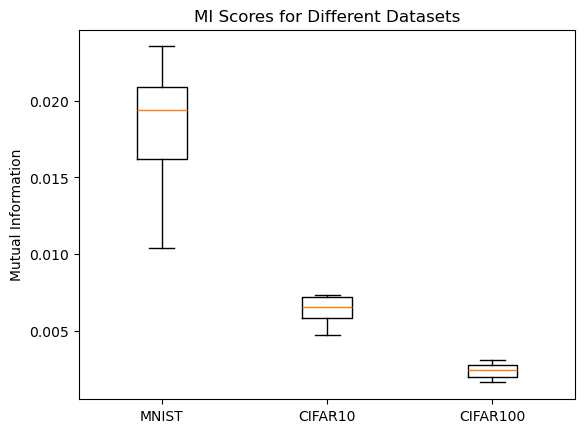

In [13]:
plt.boxplot((mnist_scores, cifar10_scores, cifar100_scores), labels = ["MNIST", "CIFAR10", "CIFAR100"], showfliers = False)
plt.title("MI Scores for Different Datasets")
plt.ylabel("Mutual Information")
plt.savefig("figures/dataset_MI_comparison.png")